## 

In [116]:
# Import necessary libraries 
import torch 
from PIL import Image 
import torchvision.transforms as transforms 

# Read a PIL image 
image = Image.open('converted_images/FSL_SEG_OAS1_0001_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_OAS2_126.png') 
  
# Define a transform to convert PIL  
# image to a Torch tensor 
transform = transforms.Compose([ 
    transforms.PILToTensor() 
]) 
  
# transform = transforms.PILToTensor() 
# Convert the PIL image to Torch tensor 
img_tensor = transform(image) 
print(0 == torch.tensor(0, dtype=torch.uint8))
# print the converted Torch tensor 
# print(img_tensor)
# for i in img_tensor:
#     for j in i:
#         for k in j:
#             if k !=0:
#                 print(k)
#                 break

tensor(True)


## Plan: 
1.) apply naive ML techniques to the csv data, try to gain insights.\\
2.) add pre-processing graph layers.\\
3.) try to infer age and other metrics.\\

## House keeping:
need to properly use 3d spacial data (from gif format)\\
start with the same cross section of each patient?



In [117]:
import os
import sklearn
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression as sk_OLS
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
import math

from sklearn.metrics import r2_score
import string
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression

In [118]:
# encode M/F, and Hand

cross_sectional = pd.read_csv("datacsv/oasis_cross-sectional.csv")
cross_sectional.fillna(value=0, inplace=True)
y = cross_sectional.CDR
X = cross_sectional.drop(["CDR", "M/F", "Hand", "ID"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y)
print(len(X_train))
print(len(y_train))
print(len(X_test))
# print(X_test)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
    


327
327
109


In [119]:
def rename(x):
    if x == "Nondemented":
        return 0.0
    elif x == "Demented" or x == "Converted":
        return 1.0
    else:
        return x

In [120]:
longitudinal = pd.read_csv("datacsv/oasis_longitudinal.csv")
cross_sectional = pd.read_csv("datacsv/oasis_cross-sectional.csv")

frames = [cross_sectional, longitudinal]
combined = pd.concat(frames)
# combined = combined.rename(columns={"Group": "CDR"})
combined = combined.map(rename)
# combined["Group"] = combined["Group"].astype('float')
# print(combined)
combined.reset_index(inplace=True, drop=True)
combined.fillna(value=0, inplace=True)
print(combined)
combined.to_csv("combined.csv")

                ID M/F Hand  Age  Educ  SES  MMSE  CDR  eTIV   nWBV    ASF  \
0    OAS1_0001_MR1   F    R   74   2.0  3.0  29.0  0.0  1344  0.743  1.306   
1    OAS1_0002_MR1   F    R   55   4.0  1.0  29.0  0.0  1147  0.810  1.531   
2    OAS1_0003_MR1   F    R   73   4.0  3.0  27.0  0.5  1454  0.708  1.207   
3    OAS1_0004_MR1   M    R   28   0.0  0.0   0.0  0.0  1588  0.803  1.105   
4    OAS1_0005_MR1   M    R   18   0.0  0.0   0.0  0.0  1737  0.848  1.010   
..             ...  ..  ...  ...   ...  ...   ...  ...   ...    ...    ...   
804              0   M    R   82   0.0  1.0  28.0  0.5  1693  0.694  1.037   
805              0   M    R   86   0.0  1.0  26.0  0.5  1688  0.675  1.040   
806              0   F    R   61   0.0  2.0  30.0  0.0  1319  0.801  1.331   
807              0   F    R   63   0.0  2.0  30.0  0.0  1327  0.796  1.323   
808              0   F    R   65   0.0  2.0  30.0  0.0  1333  0.801  1.317   

     Delay Subject ID         MRI ID  Group  Visit  MR Delay  E

In [146]:
# longitudinal = pd.read_csv("datacsv/oasis_longitudinal.csv")
# longitudinal.fillna(value=0, inplace=True)
# longitudinal = longitudinal.rename(columns={"Group": "CDR"})
# longitudinal = longitudinal.map(rename)

# # print(cross_sectional)
# # print(longitudinal)
# frames = [cross_sectional, longitudinal]
# combined = pd.concat(frames)

# print(len(cross_sectional))
# print(longitudinal)

y = combined.CDR
combined["NewEd"] = combined.Educ + combined.EDUC
X = combined.drop(["CDR", "M/F", "Hand", "Subject ID", "MRI ID", "ID", "Group", "Visit", "Educ", "EDUC", "Delay"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y)
print(len(X_train))
# print(y_train)
print(len(X_test))
print(X)
# print(X_test)
y_train = y_train.astype('int')
y_test = y_test.astype('int')

606
203
     Age  SES  MMSE  eTIV   nWBV    ASF  MR Delay  NewEd
0     74  3.0  29.0  1344  0.743  1.306       0.0    2.0
1     55  1.0  29.0  1147  0.810  1.531       0.0    4.0
2     73  3.0  27.0  1454  0.708  1.207       0.0    4.0
3     28  0.0   0.0  1588  0.803  1.105       0.0    0.0
4     18  0.0   0.0  1737  0.848  1.010       0.0    0.0
..   ...  ...   ...   ...    ...    ...       ...    ...
804   82  1.0  28.0  1693  0.694  1.037     842.0   16.0
805   86  1.0  26.0  1688  0.675  1.040    2297.0   16.0
806   61  2.0  30.0  1319  0.801  1.331       0.0   13.0
807   63  2.0  30.0  1327  0.796  1.323     763.0   13.0
808   65  2.0  30.0  1333  0.801  1.317    1608.0   13.0

[809 rows x 8 columns]


In [147]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

clf = MultinomialNB(alpha=1e-3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))

print(clf.feature_count_)

Accuracy:  0.059113300492610835
[[3.42970e+04 9.26000e+02 1.12590e+04 8.20958e+05 4.24960e+02 6.62147e+02
  1.57896e+05 4.13600e+03]
 [3.77500e+03 1.20000e+02 1.03900e+03 7.47020e+04 3.53380e+01 5.93290e+01
  1.34100e+04 4.43000e+02]
 [2.54000e+02 7.00000e+00 5.10000e+01 4.30500e+03 2.06300e+00 3.67400e+00
  1.34900e+03 3.40000e+01]]


In [155]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

clf_sgd = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-5, random_state=42)
clf_sgd.fit(X_train, y_train)
y_pred = clf_sgd.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))

# why are there three of these 
print(f"Coef\n{clf_sgd.coef_}")

coefficients = clf_sgd.coef_
# Find the top weighted coefficients
top_coefficients = sorted(enumerate(coefficients[0]), key=lambda x: abs(x[1]), reverse=True)[:8]
coef_names = ["Age", "SES", "MMSE", "eTIV", "nWBV", "ASF", "MR Delay", "NewEd"]

print(top_coefficients)
ranked = []
for i in top_coefficients:
    print(coef_names[i[0]])
    ranked.append(coef_names[i[0]])

Accuracy:  0.896551724137931
Coef
[[-5.20729919e+04 -3.25843307e+03  1.44825232e+04  4.23327006e+03
   4.40715190e+02  3.04892390e+02  3.63274893e+03 -6.97735543e+03]
 [ 4.74278794e+04  3.12276300e+03 -1.13533693e+04 -5.22513021e+03
  -4.38441790e+02 -3.38800727e+02 -4.03466845e+03  3.30748983e+03]
 [ 7.85533738e+03  2.22047636e+02 -1.50928031e+03 -1.02656806e+03
  -1.62802752e+01  2.62724188e+01 -6.72579071e+02  1.36124855e+03]]
[(0, -52072.99188713831), (2, 14482.523161246887), (7, -6977.355431534111), (3, 4233.270064983301), (6, 3632.748929810703), (1, -3258.433065286154), (4, 440.7151902194444), (5, 304.8923897947879)]
Age
MMSE
NewEd
eTIV
MR Delay
SES
nWBV
ASF


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


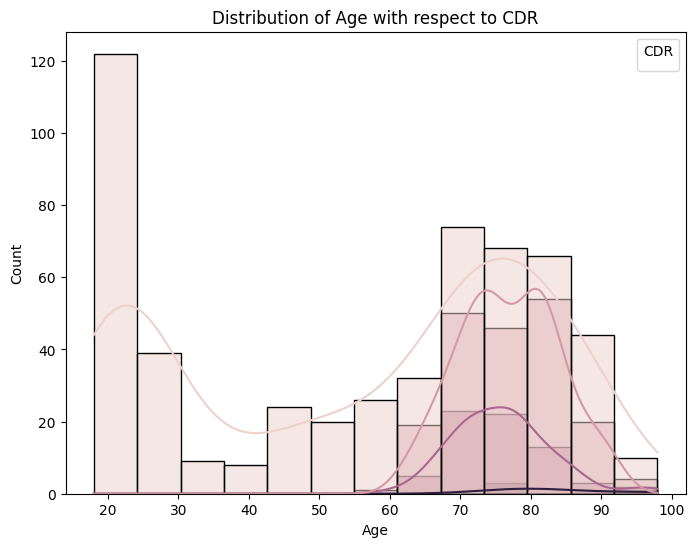

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


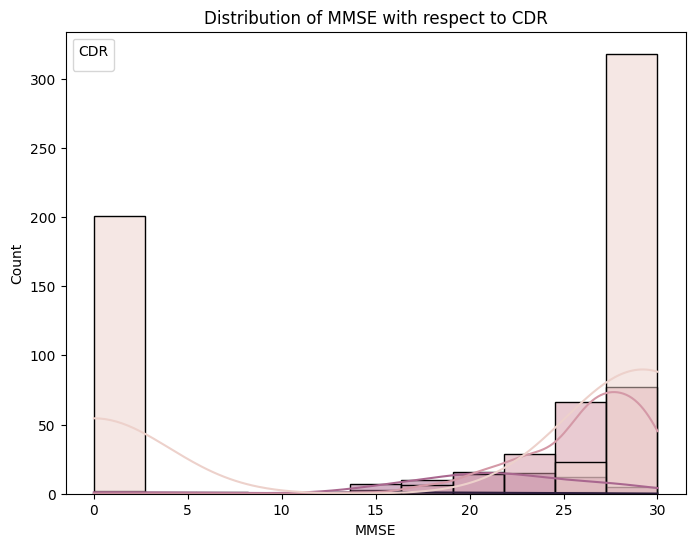

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


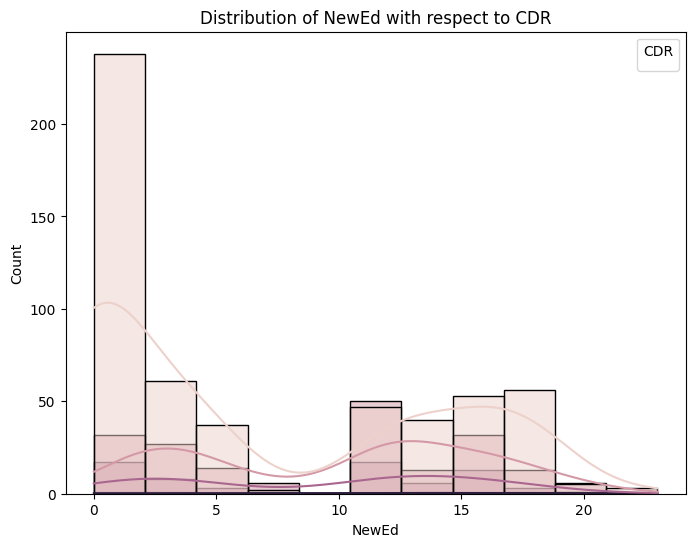

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


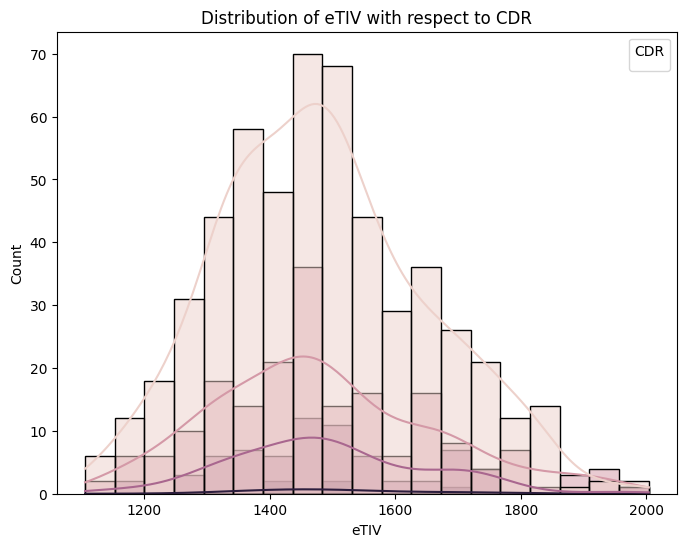

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


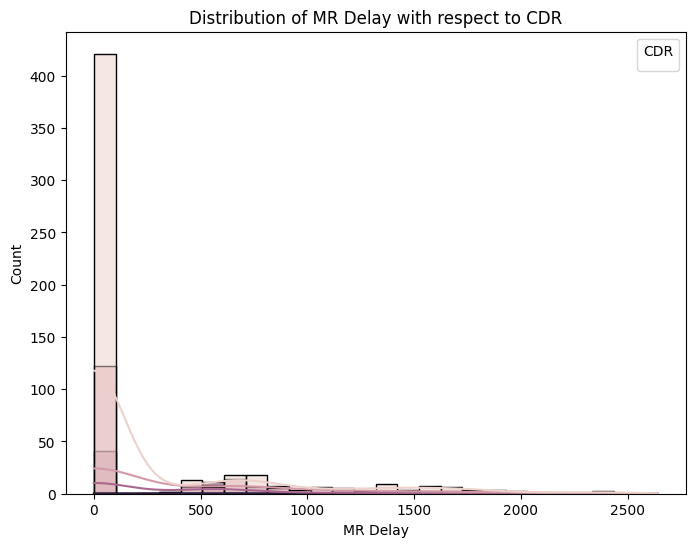

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


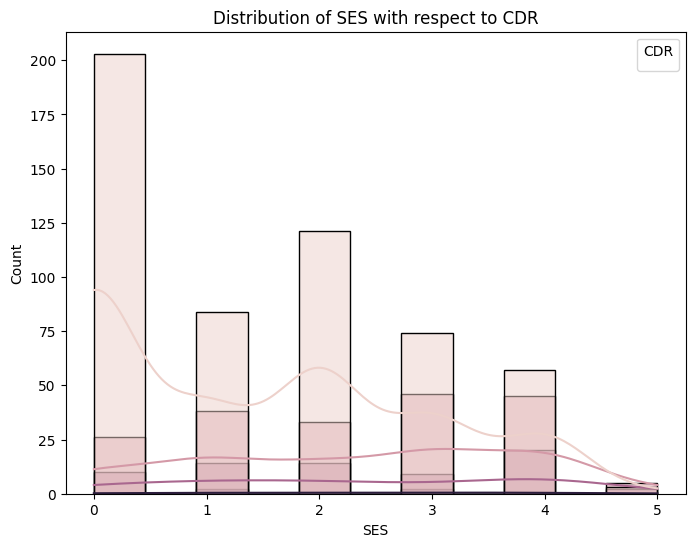

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


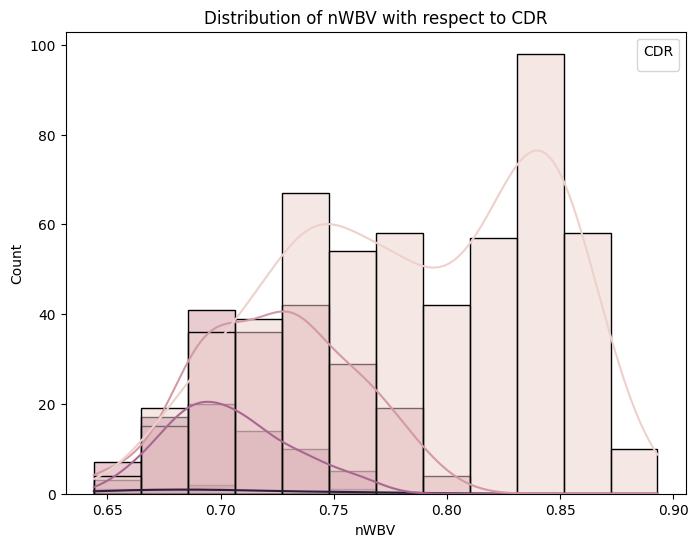

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


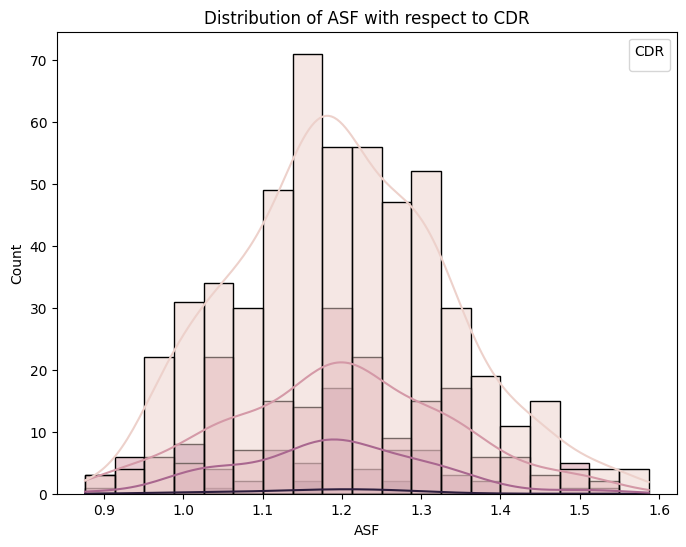

In [156]:
import seaborn as sns
import matplotlib.pyplot as plt

# Replace 'feature1', 'feature2', etc., with the actual feature column names in your dataset
# Replace 'class_label' with the actual class label column name in your dataset
features = ['feature1', 'feature2', 'feature3']  # Add all your feature column names here
features = ranked
class_label = 'CDR'

for feature in features:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=combined, x=feature, hue=class_label, kde=True)
    plt.title(f"Distribution of {feature} with respect to {class_label}")
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend(title=class_label)
    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


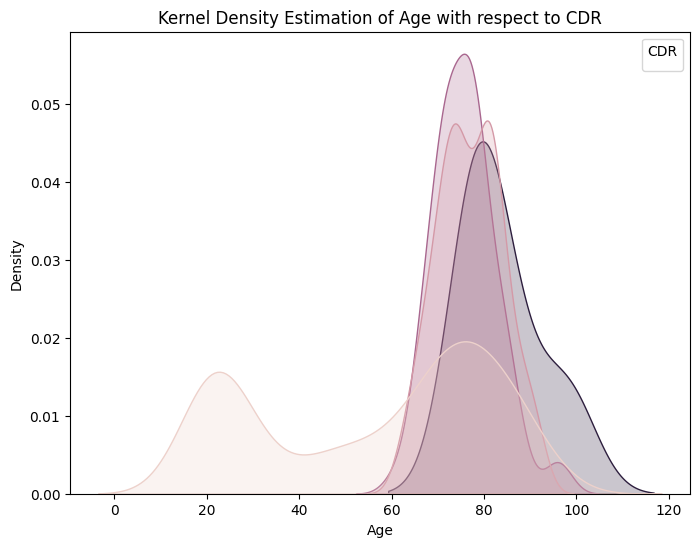

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


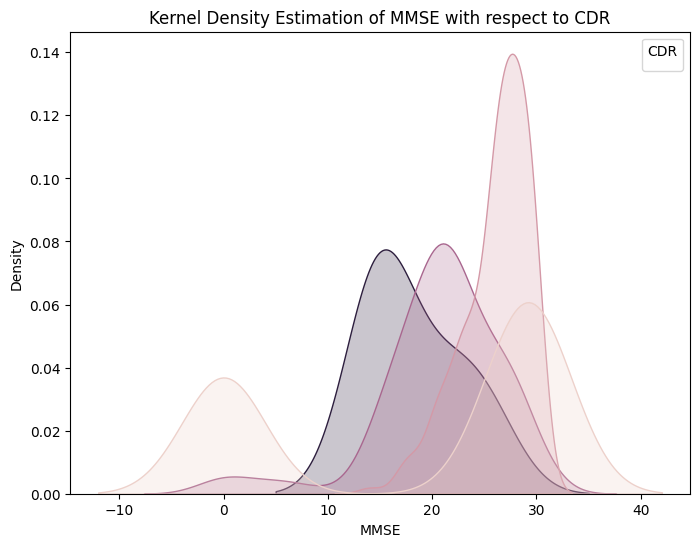

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


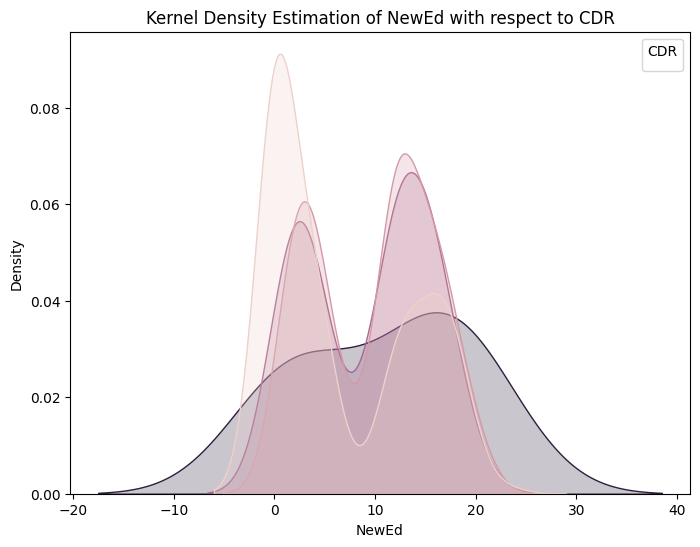

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


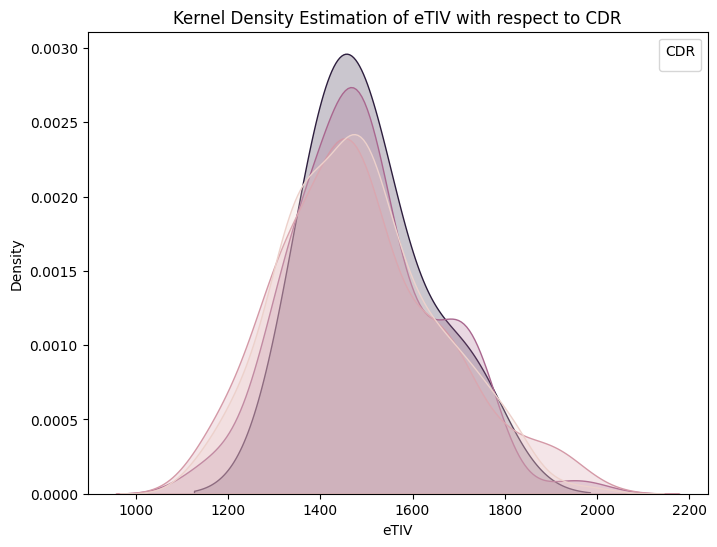

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


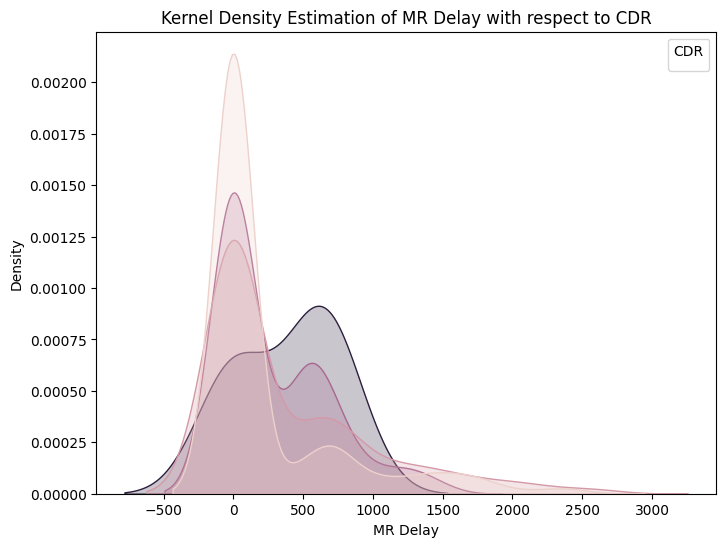

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


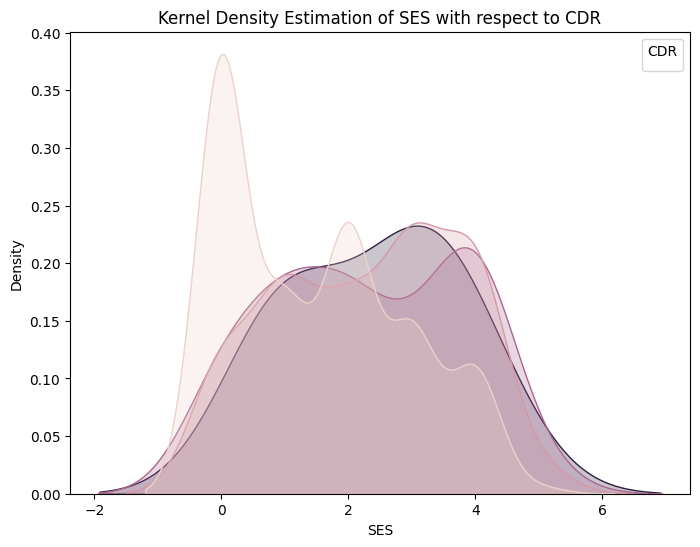

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


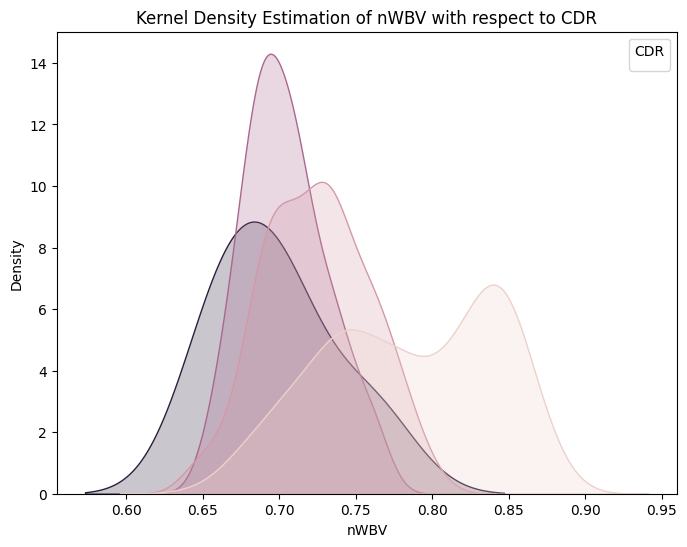

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


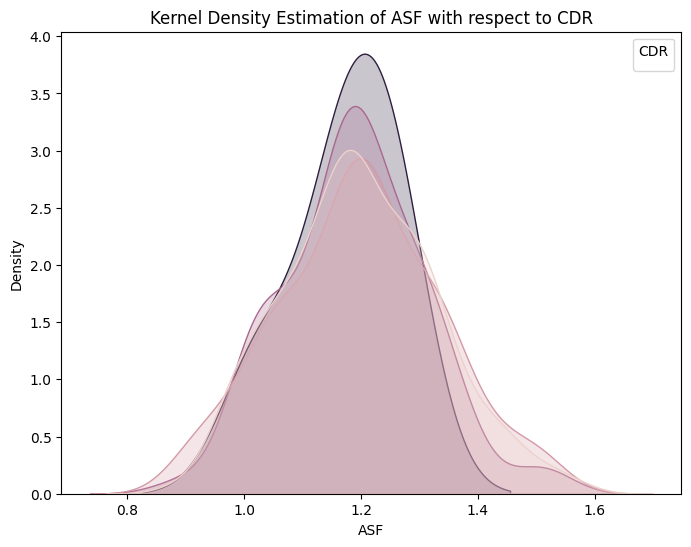

In [158]:
import seaborn as sns
import matplotlib.pyplot as plt

features = ranked
class_label = 'CDR'

for feature in features:
    plt.figure(figsize=(8, 6))
    sns.kdeplot(data=combined, x=feature, hue=class_label, fill=True, common_norm=False)
    plt.title(f"Kernel Density Estimation of {feature} with respect to {class_label}")
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend(title=class_label, )
    plt.show()



Try method with slice 99

In [124]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from pathlib import Path
import imageio.v3 as iio


In [125]:
single_slice = "converted_images/FSL_SEG_OAS1_0001_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_OAS2_99.png"

slice99 = []

pathlist = Path("converted_images").glob('*99.png')
for path in pathlist:
     # because path is object not string
     path_in_str = str(path)
     img = iio.imread(path_in_str)
     slice99.append(img)
print(combined.loc[combined['ID'] == "OAS1_0001_MR1"])
# need to correlate images to ids.
train_dataset = TensorDataset(slice99, y_train) # shuffles data generates size 32 for you
batch_size = 32 # use powers of 2 for batch sizes 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


              ID M/F Hand  Age  Educ  SES  MMSE  CDR  eTIV   nWBV    ASF  \
0  OAS1_0001_MR1   F    R   74   2.0  3.0  29.0  0.0  1344  0.743  1.306   

   Delay Subject ID MRI ID  Group  Visit  MR Delay  EDUC  
0    0.0          0      0    0.0    0.0       0.0   0.0  


NameError: name 'TensorDataset' is not defined

In [ ]:


# Define a two-layer neural network using nn.Sequential
model = nn.Sequential(
    nn.Linear(784, 32),  # Input layer to hidden layer 784 is the length of a 1d picture
    nn.ReLU(),                        # ReLU activation function
    nn.Linear(32, 10)  # Hidden layer to output layer there are 10 possible articles of clothing.
)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
num_epochs = 100
batch_size = 32

loss_array = np.zeros(num_epochs)

for epoch in range(num_epochs):
    for X_batch, y_batch in trainloader:
        re_shape = X_batch.shape[0]
        outputs = model(X_batch.view(re_shape, -1))
        loss = criterion(outputs, y_batch)
        loss_array[epoch] += loss.detach().numpy()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Evaluation
model.eval()
accuracy = []
count = 0
with torch.no_grad():
    for X_batch, y_batch in testloader: # calculate accuracy on each batch
        re_shape = X_batch.shape[0]
        outputs = model(X_batch.view(re_shape, -1))
        _, predicted = torch.max(outputs, axis=1)
        count +=1
        accuracy.append((predicted.numpy() == y_batch.numpy()).sum().item()/ y_batch.shape[0])

print(f"Max Accuracy: {max(accuracy)}")
print(f" Avg Accuracy: {sum(accuracy) * 100 / count :.2f}%")